In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

# matplotlib
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Circle
import matplotlib.dates as mdates
%matplotlib inline

import datetime

import contextily as cx

import seaborn as sns
import os
from tqdm import tqdm

import shapely
from shapely.geometry import LineString, Point
from collections import Counter

import iteround

from sklearn.neighbors import KDTree
import importlib

In [2]:
import utils
importlib.reload(utils)
import plotting_utils
importlib.reload(plotting_utils)

<module 'plotting_utils' from '/Users/francescmartiescofet/Documents/ETH/IVT/eqasim-java/switzerland/WaitTimeValidation/plotting_utils.py'>

!pip install seaborn
!pip install iteround
!pip install contextily
!pip install matplotlib-scalebar

### Load data needed

In [3]:
# get lakes
lake_path = "/Users/francescmartiescofet/Documents/ETH/IVT/SA_scenario/lake/g1s20.shp"
zurich_districts_path = "/Users/francescmartiescofet/Documents/ETH/IVT/SA_scenario/city_districts/data/stzh.adm_stadtkreise_v.shp"
df_districts = plotting_utils.get_zurich_districts_gpd(zurich_districts_path)


In [4]:
def convert_drt_legs_to_gpd(it_drt_legs):
    df = it_drt_legs.copy()
    df['origin_geometry'] = [Point(xy) for xy in zip(df.fromX, df.fromY)]
    df['destination_geometry'] = [Point(xy) for xy in zip(df.toX, df.toY)]
    df['geometry'] = df['origin_geometry']
    df = gpd.GeoDataFrame(df)
    df.crs = "epsg:2056"
    df["trip_id"] = [x for x in range(1, len(df)+1)]

    return df

In [5]:
output_directory = '/Users/francescmartiescofet/Documents/ETH/IVT/eqasim-java/switzerland/SA_scenario_output'

drt_legs = utils.get_drt_legs(output_directory)
it_drt_legs_gpd = convert_drt_legs_to_gpd(drt_legs[5])
it_drt_legs_gpd.head()

/Users/francescmartiescofet/miniconda3/envs/IVT/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/francescmartiescofet/miniconda3/envs/IVT/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


departureTime         personId vehicleId  fromLinkId       fromX  \
0        20394.0  201740003028284   drt2337      199217  2681198.89   
1        21703.0  201740003336656   drt1678      675408  2682050.18   
2        23457.0  201740003030787   drt2063      511450  2681806.44   
3        24834.0  201740003251660   drt2339      327283  2686042.63   
4        25087.0  201740003259821   drt2792      613352  2684695.46   

        fromY  toLinkId         toX         toY  waitTime  ...  travelTime  \
0  1248025.61    246162  2680254.63  1249577.36      61.0  ...       339.0   
1  1255754.71    925551  2683054.40  1255429.15      61.0  ...       334.0   
2  1249393.77    456516  2683351.32  1247924.80      61.0  ...       272.0   
3  1245901.99    796053  2686123.38  1245421.11      61.0  ...       324.0   
4  1253388.39    261041  2683030.54  1254506.93      61.0  ...       490.0   

   travelDistance_m  directTravelDistance_m  fareForLeg  latestDepartureTime  \
0           3627.25                 3627.25           0                20994   
1           1557.34                 1557.34           0                22303   
2           2730.29                 2730.29           0                24057   
3           2857.00                 2857.00           0                25434   
4           4026.41                 4026.41           0                25687   

   latestArrivalTime                origin_geometry  \
0           21064.84  POINT (2681198.89 1248025.61)   
1           22388.82  POINT (2682050.18 1255754.71)   
2           24039.08  POINT (2681806.44 1249393.77)   
3           25470.72  POINT (2686042.63 1245901.99)   
4           25936.48  POINT (2684695.46 1253388.39)   

            destination_geometry                         geometry trip_id  
0  POINT (2680254.63 1249577.36)  POINT (2681198.890 1248025.610)       1  
1   POINT (2683054.4 1255429.15)  POINT (2682050.180 1255754.710)       2  
2   POINT (2683351.32 1247924.8)  POINT (2681806.440 1249393.770)       3  
3  POINT (2686123.38 1245421.11)  POINT (2686042.630 1245901.990)       4  
4  POINT (2683030.54 1254506.93)  POINT (2684695.460 1253388.390)       5  

[5 rows x 21 columns]

### Assigning points to zones

In [6]:
## identify zones for origin location!!
df = plotting_utils.impute(it_drt_legs_gpd, df_districts, "trip_id", "district_id",fix_by_distance=False).drop("geometry", axis=1)
display(df)
#Since we are not fixing by distance, checking how many points are outside the districts
print("no. of trips outside the district: ", sum(pd.isna(df["district_id"])))

district_metrics = plotting_utils.get_metrics_for_zonal_plot(df, df_districts, "district_id", metrics=["waitTime"])

display(district_metrics)

Imputing 12  zones onto 93  points by spatial join...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.01it/s]


departureTime         personId vehicleId  fromLinkId       fromX  \
0         20394.0  201740003028284   drt2337      199217  2681198.89   
1         21703.0  201740003336656   drt1678      675408  2682050.18   
2         23457.0  201740003030787   drt2063      511450  2681806.44   
3         24834.0  201740003251660   drt2339      327283  2686042.63   
4         25087.0  201740003259821   drt2792      613352  2684695.46   
..            ...              ...       ...         ...         ...   
88        78308.0  201740003229655   drt2209      544486  2683929.59   
89        78604.0  201740003062954   drt1252      565984  2682795.57   
90        79155.0  201740003099543   drt3243      967560  2684151.52   
91        83310.0  201740003229655   drt2209      879945  2684146.24   
92        83619.0  201740003309203   drt1066      691785  2687285.47   

         fromY  toLinkId         toX         toY  waitTime  ...  travelTime  \
0   1248025.61    246162  2680254.63  1249577.36      61.0  ...       339.0   
1   1255754.71    925551  2683054.40  1255429.15      61.0  ...       334.0   
2   1249393.77    456516  2683351.32  1247924.80      61.0  ...       272.0   
3   1245901.99    796053  2686123.38  1245421.11      61.0  ...       324.0   
4   1253388.39    261041  2683030.54  1254506.93      61.0  ...       490.0   
..         ...       ...         ...         ...       ...  ...         ...   
88  1250871.77    879945  2684146.24  1251161.36      61.0  ...        93.0   
89  1250761.58    137882  2684166.51  1250677.67      61.0  ...       269.0   
90  1247759.15    997451  2682943.58  1249526.03      61.0  ...       343.0   
91  1251161.36    544486  2683929.59  1250871.77      61.0  ...        93.0   
92  1246448.69    950668  2684898.79  1246572.62      61.0  ...       441.0   

    travelDistance_m  directTravelDistance_m  fareForLeg  latestDepartureTime  \
0            3627.25                 3627.25           0                20994   
1            1557.34                 1557.34           0                22303   
2            2730.29                 2730.29           0                24057   
3            2857.00                 2857.00           0                25434   
4            4026.41                 4026.41           0                25687   
..               ...                     ...         ...                  ...   
88            491.61                  491.61           0                78908   
89           2697.96                 2697.96           0                79204   
90           2734.54                 2734.54           0                79755   
91            491.61                  491.61           0                83910   
92           3707.69                 3707.69           0                84219   

    latestArrivalTime                origin_geometry  \
0            21064.84  POINT (2681198.89 1248025.61)   
1            22388.82  POINT (2682050.18 1255754.71)   
2            24039.08  POINT (2681806.44 1249393.77)   
3            25470.72  POINT (2686042.63 1245901.99)   
4            25936.48  POINT (2684695.46 1253388.39)   
..                ...                            ...   
88           78651.20  POINT (2683929.59 1250871.77)   
89           79183.94  POINT (2682795.57 1250761.58)   
90           79765.15  POINT (2684151.52 1247759.15)   
91           83650.14  POINT (2684146.24 1251161.36)   
92           84360.34  POINT (2687285.47 1246448.69)   

             destination_geometry trip_id  district_id  
0   POINT (2680254.63 1249577.36)       1          4.0  
1    POINT (2683054.4 1255429.15)       2          NaN  
2    POINT (2683351.32 1247924.8)       3          5.0  
3   POINT (2686123.38 1245421.11)       4          7.0  
4   POINT (2683030.54 1254506.93)       5          NaN  
..                            ...     ...          ...  
88  POINT (2684146.24 1251161.36)      89         11.0  
89  POINT (2684166.51 1250677.67)      90          6.0  
90  POINT (2682943.58 1249526.0

no. of trips outside the district:  31


district_id  waitTime
0           1.0       0.0
1           2.0       1.0
2           3.0       1.2
3           4.0       1.2
4           5.0       1.0
5           6.0       1.3
6           7.0       1.0
7           8.0       1.7
8           9.0       1.1
9          10.0       1.3
10         11.0       1.2
11         12.0       0.0

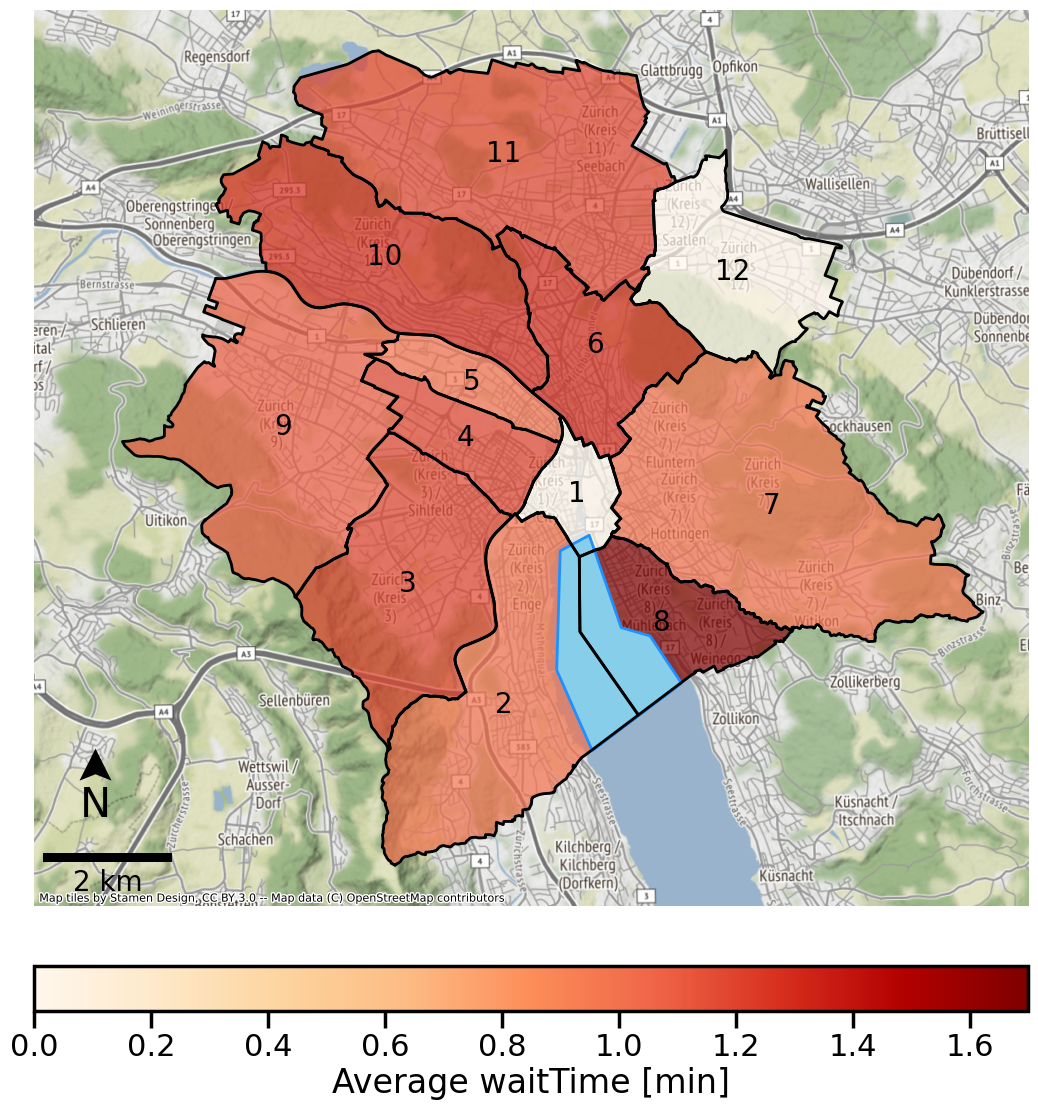

In [7]:
plotting_utils.plot_zonal_avg(district_metrics, df_districts, 
                              'waitTime', shapely.ops.unary_union([geo for geo in df_districts["geometry"]]),
                             lake_path, zurich_districts_path, add_map=True)

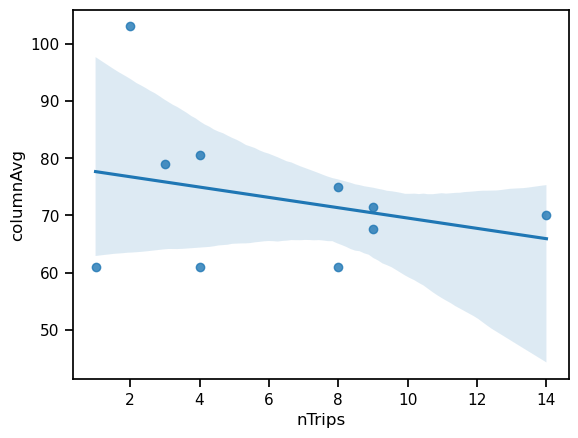

In [8]:
plotting_utils.plot_column_by_trip_density_scatter(df, 'district_id', 'waitTime')

# Use our grid

In [9]:
zurich_shp_path = '/Users/francescmartiescofet/Documents/ETH/IVT/SA_scenario/ScenarioBoundary/zurich_city_5km.shp'
zurich_shp = gpd.read_file(zurich_shp_path)
grid = utils.create_grid_from_shapefile(zurich_shp_path, 1000)

/Users/francescmartiescofet/miniconda3/envs/IVT/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [10]:
grid

geometry grid_id
494  POLYGON ((2693227.193 1248304.319, 2693227.193...   21_11
425  POLYGON ((2690227.193 1248304.319, 2690227.193...   18_11
470  POLYGON ((2692227.193 1249304.319, 2692227.193...   20_10
516  POLYGON ((2693446.571 1249304.319, 2693457.964...   22_10
424  POLYGON ((2690227.193 1249304.319, 2690227.193...   18_10
..                                                 ...     ...
153  POLYGON ((2678227.193 1244304.319, 2678227.193...    6_15
199  POLYGON ((2680227.193 1244304.319, 2680227.193...    8_15
61   POLYGON ((2674227.193 1244304.319, 2674227.193...    2_15
176  POLYGON ((2679227.193 1244304.319, 2679227.193...    7_15
107  POLYGON ((2676227.193 1244304.319, 2676227.193...    4_15

[429 rows x 2 columns]

In [11]:
grid_drt_legs = plotting_utils.impute(it_drt_legs_gpd, grid, "trip_id", "grid_id",fix_by_distance=False).drop("geometry", axis=1)
display(grid_drt_legs)
#Since we are not fixing by distance, checking how many points are outside the districts
print("no. of trips outside the district: ", sum(pd.isna(grid_drt_legs["grid_id"])))
grid_metrics = plotting_utils.get_metrics_for_zonal_plot(grid_drt_legs, grid, "grid_id", metrics=["waitTime"])
display(grid_metrics)

Imputing 429  zones onto 93  points by spatial join...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.96it/s]


departureTime         personId vehicleId  fromLinkId       fromX  \
0         20394.0  201740003028284   drt2337      199217  2681198.89   
1         21703.0  201740003336656   drt1678      675408  2682050.18   
2         23457.0  201740003030787   drt2063      511450  2681806.44   
3         24834.0  201740003251660   drt2339      327283  2686042.63   
4         25087.0  201740003259821   drt2792      613352  2684695.46   
..            ...              ...       ...         ...         ...   
88        78308.0  201740003229655   drt2209      544486  2683929.59   
89        78604.0  201740003062954   drt1252      565984  2682795.57   
90        79155.0  201740003099543   drt3243      967560  2684151.52   
91        83310.0  201740003229655   drt2209      879945  2684146.24   
92        83619.0  201740003309203   drt1066      691785  2687285.47   

         fromY  toLinkId         toX         toY  waitTime  ...  travelTime  \
0   1248025.61    246162  2680254.63  1249577.36      61.0  ...       339.0   
1   1255754.71    925551  2683054.40  1255429.15      61.0  ...       334.0   
2   1249393.77    456516  2683351.32  1247924.80      61.0  ...       272.0   
3   1245901.99    796053  2686123.38  1245421.11      61.0  ...       324.0   
4   1253388.39    261041  2683030.54  1254506.93      61.0  ...       490.0   
..         ...       ...         ...         ...       ...  ...         ...   
88  1250871.77    879945  2684146.24  1251161.36      61.0  ...        93.0   
89  1250761.58    137882  2684166.51  1250677.67      61.0  ...       269.0   
90  1247759.15    997451  2682943.58  1249526.03      61.0  ...       343.0   
91  1251161.36    544486  2683929.59  1250871.77      61.0  ...        93.0   
92  1246448.69    950668  2684898.79  1246572.62      61.0  ...       441.0   

    travelDistance_m  directTravelDistance_m  fareForLeg  latestDepartureTime  \
0            3627.25                 3627.25           0                20994   
1            1557.34                 1557.34           0                22303   
2            2730.29                 2730.29           0                24057   
3            2857.00                 2857.00           0                25434   
4            4026.41                 4026.41           0                25687   
..               ...                     ...         ...                  ...   
88            491.61                  491.61           0                78908   
89           2697.96                 2697.96           0                79204   
90           2734.54                 2734.54           0                79755   
91            491.61                  491.61           0                83910   
92           3707.69                 3707.69           0                84219   

    latestArrivalTime                origin_geometry  \
0            21064.84  POINT (2681198.89 1248025.61)   
1            22388.82  POINT (2682050.18 1255754.71)   
2            24039.08  POINT (2681806.44 1249393.77)   
3            25470.72  POINT (2686042.63 1245901.99)   
4            25936.48  POINT (2684695.46 1253388.39)   
..                ...                            ...   
88           78651.20  POINT (2683929.59 1250871.77)   
89           79183.94  POINT (2682795.57 1250761.58)   
90           79765.15  POINT (2684151.52 1247759.15)   
91           83650.14  POINT (2684146.24 1251161.36)   
92           84360.34  POINT (2687285.47 1246448.69)   

             destination_geometry trip_id  grid_id  
0   POINT (2680254.63 1249577.36)       1     9_11  
1    POINT (2683054.4 1255429.15)       2     10_3  
2    POINT (2683351.32 1247924.8)       3     10_9  
3   POINT (2686123.38 1245421.11)       4    14_13  
4   POINT (2683030.54 1254506.93)       5     13_5  
..                            ...     ...      ...  
88  POINT (2684146.24 1251161.36)      89     12_8  
89  POINT (2684166.51 1250677.67)      90     11_8  
90  POINT (2682943.58 1249526.03)      91    12_11  
91  POINT (268

no. of trips outside the district:  0


grid_id  waitTime
0      0_10       0.0
1      0_11       0.0
2      0_12       0.0
3      0_13       0.0
4      0_14       0.0
..      ...       ...
424     9_5       0.0
425     9_6       0.0
426     9_7       1.4
427     9_8       0.0
428     9_9       1.0

[429 rows x 2 columns]

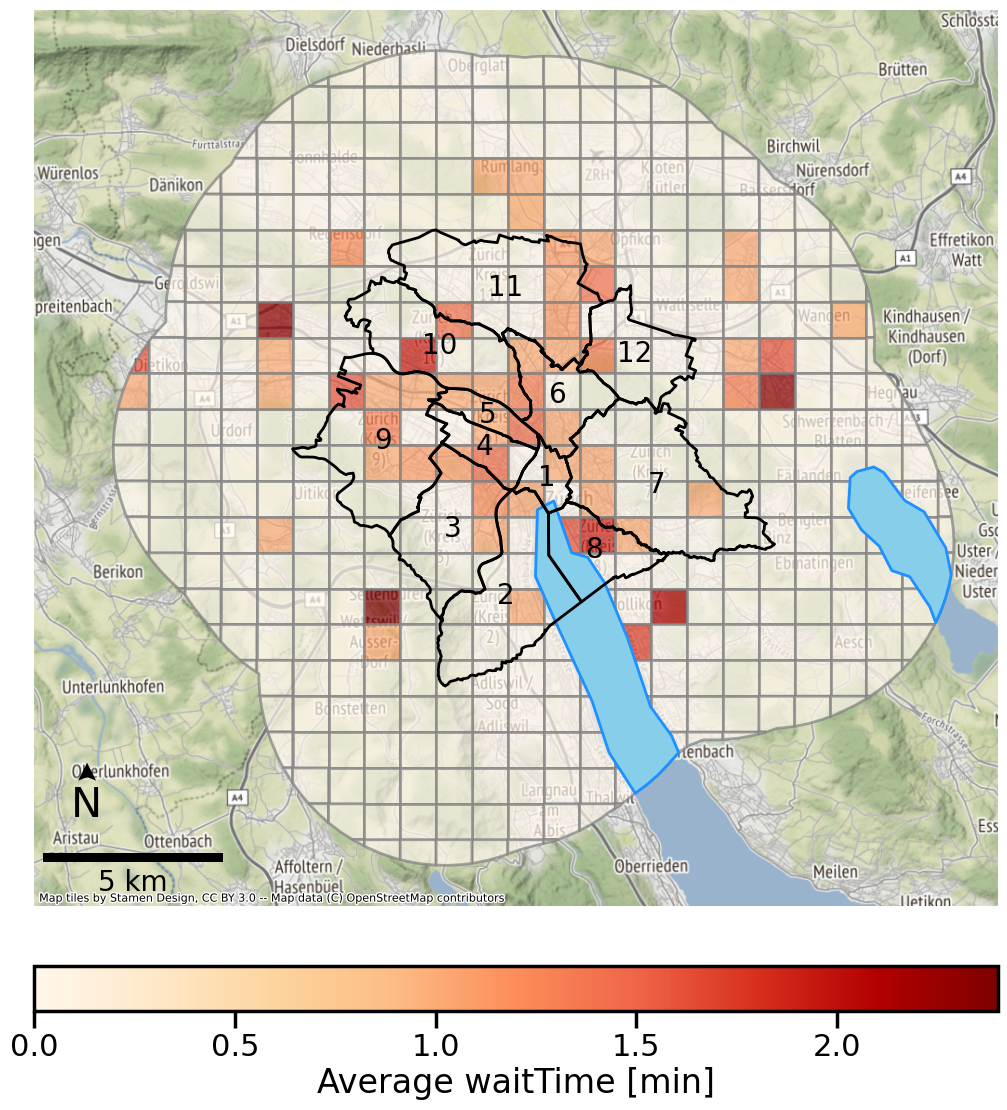

In [12]:
plotting_utils.plot_zonal_avg(grid_metrics, grid, 'waitTime', 
                              zurich_shp.loc[0].geometry, lake_path, zurich_districts_path, add_map=True)

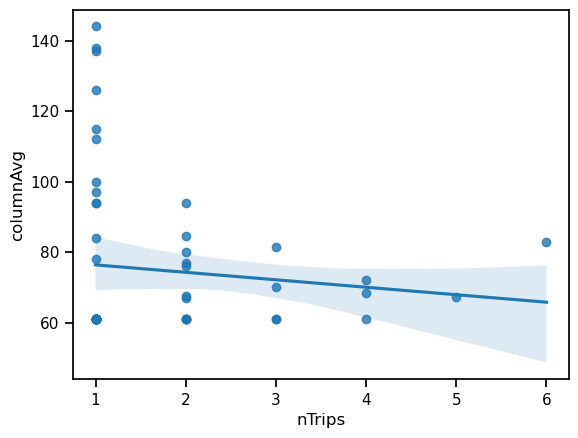

In [13]:
plotting_utils.plot_column_by_trip_density_scatter(grid_drt_legs, 'grid_id', 'waitTime')

# Testing with output from class project

In [14]:
class_project_drt_legs_gdf = convert_drt_legs_to_gpd(pd.read_csv('/Users/francescmartiescofet/Desktop/28.drt_trips_drt.csv', sep=';'))

/Users/francescmartiescofet/miniconda3/envs/IVT/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/francescmartiescofet/miniconda3/envs/IVT/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [15]:
class_project_drt_legs_gdf

departureTime         personId vehicleId  fromLinkId       fromX  \
0               33.0  201740010683213   drt3356      211875  2679787.33   
1               36.0  201740010451177   drt1281      215298  2676574.54   
2               37.0  201740009842715   drt3848      253250  2684841.48   
3               41.0  201740003622835   drt2945      329394  2686858.53   
4               44.0  201740007721765    drt883      644309  2681088.72   
...              ...              ...       ...         ...         ...   
88850       106508.0  201740004345615   drt2372      462552  2684121.02   
88851       106513.0  201740003906606   drt2544      193966  2682651.37   
88852       106581.0  201740006253397   drt1462      644372  2681511.90   
88853       106634.0  201740004880949   drt3815      376659  2684538.51   
88854       106723.0  201740007852691   drt2997      624217  2681508.48   

            fromY  toLinkId         toX         toY  waitTime  arrivalTime  \
0      1250708.55    364724  2682983.54  1251935.52     112.0        745.0   
1      1250203.97    151179  2674395.66  1247008.94      31.0        903.0   
2      1253046.32    364724  2682983.54  1251935.52     104.0        508.0   
3      1250489.90    364724  2682983.54  1251935.52     365.0       1204.0   
4      1252916.96    789074  2683215.51  1248676.27     295.0       1356.0   
...           ...       ...         ...         ...       ...          ...   
88850  1246098.93    516964  2687458.81  1244684.47     152.0     107308.0   
88851  1247493.68     30182  2685572.68  1248520.54     399.0     107784.0   
88852  1248373.10    410256  2685912.65  1251076.99      67.0     107338.0   
88853  1253141.39    949133  2682995.52  1251283.11      93.0     107149.0   
88854  1248932.37    301508  2687020.44  1251267.14     151.0     107461.0   

       travelTime  travelDistance_m  direcTravelDistance_m  \
0           600.0           4389.29                4389.29   
1           836.0           7633.48                6707.79   
2           367.0           2775.24                2775.24   
3           798.0           5154.32                5154.32   
4          1017.0           6358.01                6358.01   
...           ...               ...                    ...   
88850       648.0           4588.50                4588.50   
88851       872.0           5431.43                5431.43   
88852       690.0           6709.98                6709.98   
88853       422.0           3175.27                3175.27   
88854       587.0           8274.78                8274.78   

                     origin_geometry           destination_geometry  \
0      POINT (2679787.33 1250708.55)  POINT (2682983.54 1251935.52)   
1      POINT (2676574.54 1250203.97)  POINT (2674395.66 1247008.94)   
2      POINT (2684841.48 1253046.32)  POINT (2682983.54 1251935.52)   
3       POINT (2686858.53 1250489.9)  POINT (2682983.54 1251935.52)   
4      POINT (2681088.72 1252916.96)  POINT (2683215.51 1248676.27)   
...                              ...                            ...   
88850  POINT (2684121.02 1246098.93)  POINT (2687458.81 1244684.47)   
88851  POINT (2682651.37 1247493.68)  POINT (2685572.68 1248520.54)   
88852    POINT (2681511.9 1248373.1)  POINT (2685912.65 1251076.99)   
88853  POINT (2684538.51 1253141.39)  POINT (2682995.52 1251283.11)   
88854  POINT (2681508.48 1248932.37)  POINT (2687020.44 1251267.14)   

                              geometry  trip_id  
0      POINT (2679787.330 1250708.550)        1  
1      POINT (2676574.540 1250203.970)        2  
2      POINT (2684841.480 1253046.320)        3  
3      POINT (2686858.530 1250489.900)        4  
4      POINT (2681088.720 1252916.960)        5  
...                                ...      ...  
88850  POINT (2684121.020 1246098.930)    88851  
88851  POINT (2682651.370 1247493.680)    88852  
88852  POINT (2681511.900 1248373.100)    88853  
88853  POINT (2684538.510 1253141.390)    88854  
88854  POINT (2681508

In [16]:
grid_drt_legs_class = plotting_utils.impute(class_project_drt_legs_gdf, grid, "trip_id", "grid_id",fix_by_distance=True).drop("geometry", axis=1)
display(grid_drt_legs_class)
#Since we are not fixing by distance, checking how many points are outside the districts
print("no. of trips outside the district: ", sum(pd.isna(grid_drt_legs_class["grid_id"])))
grid_metrics_class = plotting_utils.get_metrics_for_zonal_plot(grid_drt_legs_class, grid, "grid_id", metrics=["waitTime"])

Imputing 429  zones onto 88855  points by spatial join...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.27it/s]

  Fixing 85 points by centroid distance join...


departureTime         personId vehicleId  fromLinkId       fromX  \
0               33.0  201740010683213   drt3356      211875  2679787.33   
1               36.0  201740010451177   drt1281      215298  2676574.54   
2               37.0  201740009842715   drt3848      253250  2684841.48   
3               41.0  201740003622835   drt2945      329394  2686858.53   
4               44.0  201740007721765    drt883      644309  2681088.72   
...              ...              ...       ...         ...         ...   
88850       106508.0  201740004345615   drt2372      462552  2684121.02   
88851       106513.0  201740003906606   drt2544      193966  2682651.37   
88852       106581.0  201740006253397   drt1462      644372  2681511.90   
88853       106634.0  201740004880949   drt3815      376659  2684538.51   
88854       106723.0  201740007852691   drt2997      624217  2681508.48   

            fromY  toLinkId         toX         toY  waitTime  arrivalTime  \
0      1250708.55    364724  2682983.54  1251935.52     112.0        745.0   
1      1250203.97    151179  2674395.66  1247008.94      31.0        903.0   
2      1253046.32    364724  2682983.54  1251935.52     104.0        508.0   
3      1250489.90    364724  2682983.54  1251935.52     365.0       1204.0   
4      1252916.96    789074  2683215.51  1248676.27     295.0       1356.0   
...           ...       ...         ...         ...       ...          ...   
88850  1246098.93    516964  2687458.81  1244684.47     152.0     107308.0   
88851  1247493.68     30182  2685572.68  1248520.54     399.0     107784.0   
88852  1248373.10    410256  2685912.65  1251076.99      67.0     107338.0   
88853  1253141.39    949133  2682995.52  1251283.11      93.0     107149.0   
88854  1248932.37    301508  2687020.44  1251267.14     151.0     107461.0   

       travelTime  travelDistance_m  direcTravelDistance_m  \
0           600.0           4389.29                4389.29   
1           836.0           7633.48                6707.79   
2           367.0           2775.24                2775.24   
3           798.0           5154.32                5154.32   
4          1017.0           6358.01                6358.01   
...           ...               ...                    ...   
88850       648.0           4588.50                4588.50   
88851       872.0           5431.43                5431.43   
88852       690.0           6709.98                6709.98   
88853       422.0           3175.27                3175.27   
88854       587.0           8274.78                8274.78   

                     origin_geometry           destination_geometry  trip_id  \
0      POINT (2679787.33 1250708.55)  POINT (2682983.54 1251935.52)        1   
1      POINT (2676574.54 1250203.97)  POINT (2674395.66 1247008.94)        2   
2      POINT (2684841.48 1253046.32)  POINT (2682983.54 1251935.52)        3   
3       POINT (2686858.53 1250489.9)  POINT (2682983.54 1251935.52)        4   
4      POINT (2681088.72 1252916.96)  POINT (2683215.51 1248676.27)        5   
...                              ...                            ...      ...   
88850  POINT (2684121.02 1246098.93)  POINT (2687458.81 1244684.47)    88851   
88851  POINT (2682651.37 1247493.68)  POINT (2685572.68 1248520.54)    88852   
88852    POINT (2681511.9 1248373.1)  POINT (2685912.65 1251076.99)    88853   
88853  POINT (2684538.51 1253141.39)  POINT (2682995.52 1251283.11)    88854   
88854  POINT (2681508.48 1248932.37)  POINT (2687020.44 1251267.14)    88855   

      grid_id  
0         8_8  
1         5_9  
2        13_6  
3        15_8  
4         9_6  
...       ...  
88850   12_13  
88851   11_11  
88852   10_10  
88853    13_6  
88854   10_10  

[88855 rows x 18 columns]

no. of trips outside the district:  0


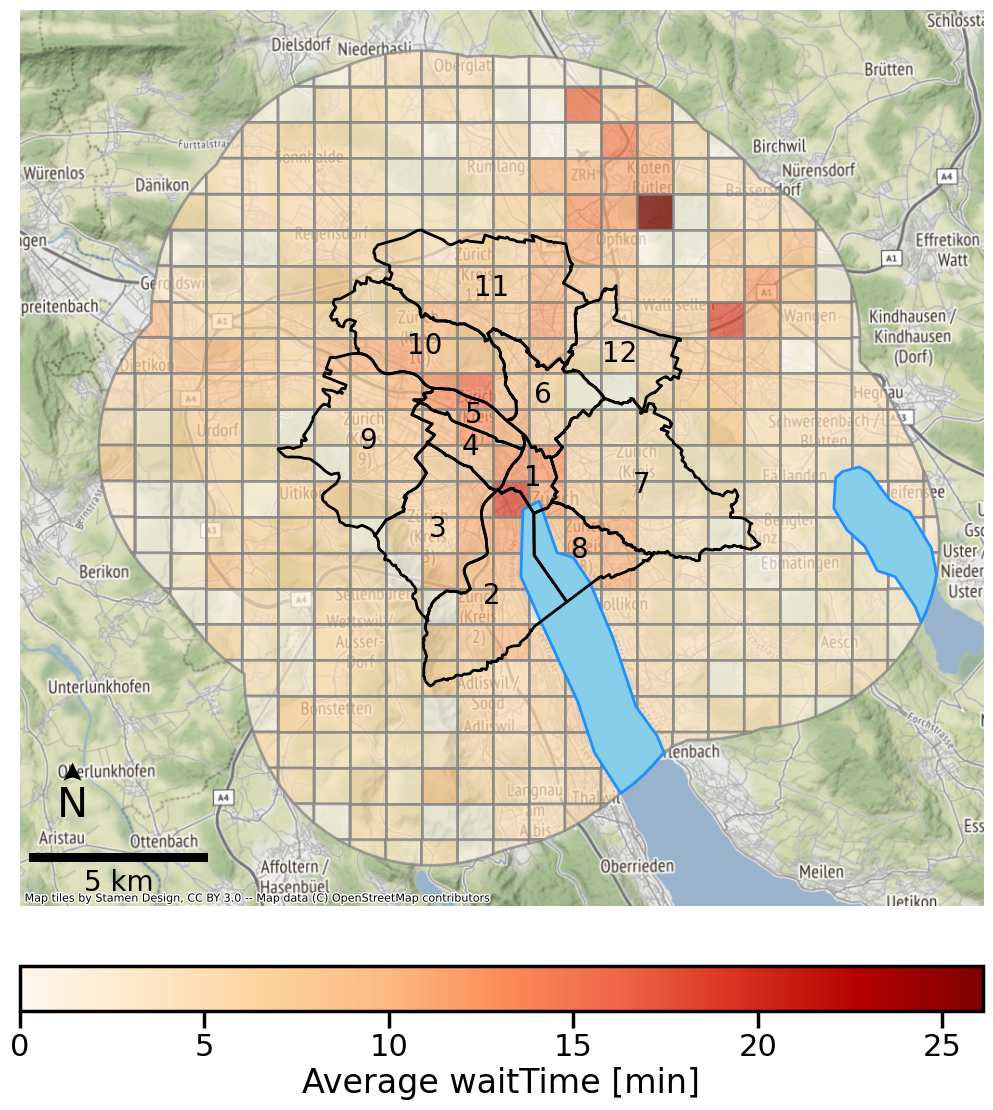

In [17]:
plotting_utils.plot_zonal_avg(grid_metrics_class, grid, 'waitTime', 
                              zurich_shp.loc[0].geometry, lake_path, zurich_districts_path, add_map=True)

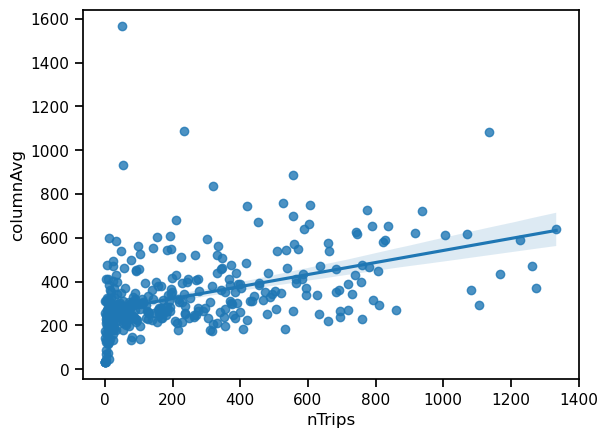

In [18]:
plotting_utils.plot_column_by_trip_density_scatter(grid_drt_legs_class, 'grid_id', 'waitTime')